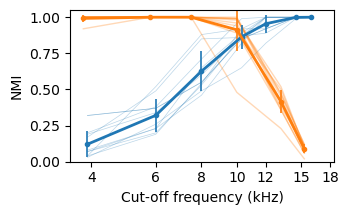

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helper: load architectures from one file ----------
def load_architectures_freq_nmi_r2(filename):
    """
    File format (multiple architectures, separated by blank lines):
        3800Hz 1.00 0.68
        5800Hz 1.00 0.53
        ...
    Returns:
        freqs_khz: (n_arch, n_points)
        nmi:       (n_arch, n_points)
        r2:        (n_arch, n_points)
    """
    with open(filename, "r") as f:
        raw = f.read().strip()

    # Split into blocks by blank lines (one block per architecture)
    blocks = [b.strip() for b in raw.split("\n\n") if b.strip()]

    freq_list = []
    nmi_list = []
    r2_list  = []

    for b in blocks:
        freqs = []
        nmis  = []
        r2s   = []

        for line in b.splitlines():
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            parts = line.split()
            # Expect something like: "3800Hz 1.00 0.68"
            freq_str = parts[0].replace("Hz", "")
            freq_hz  = float(freq_str)
            nmi_val  = float(parts[1])
            r2_val   = float(parts[2]) if len(parts) > 2 else np.nan

            freqs.append(freq_hz / 1000.0)  # Hz → kHz
            nmis.append(nmi_val)
            r2s.append(r2_val)

        freq_list.append(np.array(freqs))
        nmi_list.append(np.array(nmis))
        r2_list.append(np.array(r2s))

    freqs_khz = np.stack(freq_list, axis=0)  # (n_arch, n_points)
    nmi       = np.stack(nmi_list,  axis=0)
    r2        = np.stack(r2_list,   axis=0)

    return freqs_khz, nmi, r2


# ---------- 1. Load both low20 and high20k ----------
file_low  = "mp_spectral_low20_neighours=50"       # add extension if needed
file_high = "mp_spectral_high20k_neighours=50"    # add extension if needed

freq_low_archs,  nmi_low_archs,  r2_low_archs  = load_architectures_freq_nmi_r2(file_low)
freq_high_archs, nmi_high_archs, r2_high_archs = load_architectures_freq_nmi_r2(file_high)

# assume frequencies are the same across architectures within each file
freq_low_khz  = freq_low_archs[0]
freq_high_khz = freq_high_archs[0]

# ---------- 2. Mean and std across architectures (raw NMI) ----------
mean_nmi_low  = nmi_low_archs.mean(axis=0)
std_nmi_low   = nmi_low_archs.std(axis=0)
mean_nmi_high = nmi_high_archs.mean(axis=0)
std_nmi_high  = nmi_high_archs.std(axis=0)


# ---------- 3. Plot ----------
fig, ax = plt.subplots(figsize=(3.5, 2.25))

# --- Individual architectures: low20 (blue, semi-transparent) ---
for i in range(nmi_low_archs.shape[0]):
    ax.plot(
        freq_low_khz,
        nmi_low_archs[i],
        marker="o",
        linewidth=0.5,
        markersize=0,
        alpha=0.3,
        color="C0",    # blue
    )
    if i==0:
        ax.plot(
            freq_low_khz,
            nmi_low_archs[i],
            marker="o",
            linewidth=0.5,
            markersize=0,
            alpha=0.3,
            color="C0",    # blue      
            label="Arch#",    
        )
    

# --- Individual architectures: high20k (orange, semi-transparent) ---
for i in range(nmi_high_archs.shape[0]):
    ax.plot(
        freq_high_khz,
        nmi_high_archs[i],
        marker="o",
        linewidth=1,
        markersize=0,
        alpha=0.3,
        color="C1",    # orange
    )

# --- Mean ± s.d. with error bars: low20 ---
ax.errorbar(
    freq_low_khz,
    mean_nmi_low,
    yerr=std_nmi_low,
    fmt="o-",
    linewidth=2,
    color="C0",
    ecolor="C0",
    elinewidth=1.2,
    markersize=3,
    capsize=0,
    label="Low pass",
)

# --- Mean ± s.d. with error bars: high20k ---
ax.errorbar(
    freq_high_khz,
    mean_nmi_high,
    yerr=std_nmi_high,
    fmt="o-",
    linewidth=2,
    color="C1",
    ecolor="C1",
    elinewidth=1.2,
    markersize=3,
    capsize=0,
    label="High pass", ##  (mean ± s.d.)
)

# ---------- X-axis: log2 scale with custom tick labels ----------
ax.set_xscale("log", base=2)   # log₂ scale

xticks = np.array([4, 6, 8, 10, 12, 15, 18], dtype=np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])  # keep labels as 4, 6, 8, ...

ax.set_xlim(3.5, 18.5)
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cut-off frequency (kHz)")
ax.set_ylabel("NMI")

# ax.grid(True, which="both", alpha=0.3)
# ax.legend(frameon=False, loc='center left')
# ax.legend(frameon=False, loc='center left', bbox_to_anchor=(0, 0.7))

# ax.legend(frameon=False)

plt.tight_layout()
plt.savefig('IHC3000_A1-10_spetral2NMI_neighbor=50.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [2]:
r2_low_archs

array([[0.51, 0.66, 0.8 , 0.86, 0.39, 0.22, 0.26],
       [0.19, 0.64, 0.89, 0.62, 0.66, 0.15, 0.23],
       [0.01, 0.39, 0.77, 0.62, 0.97, 0.58, 0.73],
       [0.3 , 0.58, 0.81, 0.63, 0.43, 0.3 , 0.  ],
       [0.05, 0.12, 0.68, 0.63, 0.68, 0.21, 0.62],
       [0.17, 0.59, 0.83, 0.76, 0.85, 0.15, 0.3 ],
       [0.07, 0.29, 0.78, 0.83, 0.61, 0.26, 0.22],
       [0.05, 0.29, 0.68, 0.65, 0.84, 0.33, 0.67],
       [0.  , 0.07, 0.81, 0.49, 0.58, 0.56, 0.58],
       [0.  , 0.45, 0.84, 0.67, 0.96, 0.76, 0.31]])

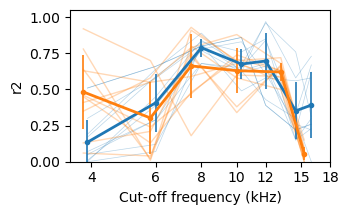

In [3]:
mean_r2_low  = r2_low_archs.mean(axis=0)
std_r2_low   = r2_low_archs.std(axis=0)
mean_r2_high = r2_high_archs.mean(axis=0)
std_r2_high  = r2_high_archs.std(axis=0)


# ---------- 3. Plot ----------
fig, ax = plt.subplots(figsize=(3.5, 2.25))

# --- Individual architectures: low20 (blue, semi-transparent) ---
for i in range(r2_low_archs.shape[0]):
    ax.plot(
        freq_low_khz,
        r2_low_archs[i],
        marker="o",
        linewidth=0.5,
        markersize=0,
        alpha=0.3,
        color="C0",    # blue
    )
    if i==0:
        ax.plot(
            freq_low_khz,
            r2_low_archs[i],
            marker="o",
            linewidth=0.5,
            markersize=0,
            alpha=0.3,
            color="C0",    # blue      
            label="Arch#",    
        )
    

# --- Individual architectures: high20k (orange, semi-transparent) ---
for i in range(r2_high_archs.shape[0]):
    ax.plot(
        freq_high_khz,
        r2_high_archs[i],
        marker="o",
        linewidth=1,
        markersize=0,
        alpha=0.3,
        color="C1",    # orange
    )

# --- Mean ± s.d. with error bars: low20 ---
ax.errorbar(
    freq_low_khz,
    mean_r2_low,
    yerr=std_r2_low,
    fmt="o-",
    linewidth=2,
    color="C0",
    ecolor="C0",
    elinewidth=1.2,
    markersize=3,
    capsize=0,
    label="Low pass",
)

# --- Mean ± s.d. with error bars: high20k ---
ax.errorbar(
    freq_high_khz,
    mean_r2_high,
    yerr=std_r2_high,
    fmt="o-",
    linewidth=2,
    color="C1",
    ecolor="C1",
    elinewidth=1.2,
    markersize=3,
    capsize=0,
    label="High pass", ##  (mean ± s.d.)
)

# ---------- X-axis: log2 scale with custom tick labels ----------
ax.set_xscale("log", base=2)   # log₂ scale

xticks = np.array([4, 6, 8, 10, 12, 15, 18], dtype=np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])  # keep labels as 4, 6, 8, ...

ax.set_xlim(3.5, 18)
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cut-off frequency (kHz)")
ax.set_ylabel("r2")

# ax.grid(True, which="both", alpha=0.3)
# ax.legend(frameon=False, loc='center left')
# ax.legend(frameon=False, loc='center left', bbox_to_anchor=(0, 0.95))
# ax.legend(frameon=False)

plt.tight_layout()
plt.savefig('IHC3000_A1-10_spetral2R2_neighbor=50.pdf', dpi=300, bbox_inches='tight')
plt.show()
